# Load UAVSAR from SnowEX project w/ xarray

Note: data was first converted to multiband netCDF with GDAL

In [16]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def get_metadata(infile):
    ''' read UAVSAR metadata into python dictionary '''
    annfile = infile.split('.')[0] + '.ann'

    with open(annfile) as ann:
        lines = ann.readlines()
        
    # keep only lines with keys and values
    keep = [x for x in lines if '=' in x]
    keys = [x.split('=')[0].split('(')[0].rstrip() for x in keep]
    vals = [x.split('=')[1] for x in keep]
    values = [v.split(';')[0].strip() for v in vals] #clean up
    meta = dict(zip(keys, values))

    # Just keep metadata of interest
    mykeys = ['Slant Range Data Azimuth Spacing',
              'Slant Range Data Range Spacing',
              'Number of Looks in Range',
              'Number of Looks in Azimuth',
              'Single Look Complex Data Azimuth Spacing',
              'Single Look Complex Data Range Spacing',
              'Average Look Angle in Near Range',
              'Average Look Angle in Far Range',
              'Radar Look Direction',
              'Acquisition Mode',
              'Center Wavelength',
              'Start Time of Acquisition for Pass 1',
              'Stop Time of Acquisition for Pass 1',
              'Start Time of Acquisition for Pass 2',
              'Stop Time of Acquisition for Pass 2',
              'Peg Heading',
              'Global Average Altitude',
              'Polarization',
              'DEM Source',
             ]
    myvals = [meta[x] for x in mykeys]
    mymeta = dict(zip(mykeys, myvals))
    
    return mymeta

In [18]:
ls tellur*nc

tellur_1701T_17016-005_17018-005_0003d_s01_L090HH_01.cor.grd.nc
tellur_1701T_17016-005_17018-005_0003d_s01_L090HH_01.hgt.grd.nc
tellur_1701T_17016.nc
tellur_1701T_17016_f4.nc
tellur_1701T_17016_mod.nc


In [19]:
#ds = xr.open_mfdataset('tellur_1701T*.nc') #designed to load many files via dask (for example with different timestamps)
#ds = xr.open_mfdataset('tellur_1701T_17016.nc').load() #into memory
#ds = xr.open_dataset('tellur_1701T_17016.nc').astype('f4') #error
# What about compression? lots of zeros/nans in radar swath data

ds = xr.open_dataset('tellur_1701T_17016.nc') # In memory?!

In [20]:
ds

<xarray.Dataset>
Dimensions:  (lat: 10460, lon: 6490)
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Data variables:
    Band1    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Band2    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Band3    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Band4    (lat, lon) float64 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 ...
    Band5    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    crs      |S1 b''
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.1.4, released 2017/06/23
    history:      Thu Sep 14 16:44:20 2017: GDAL Create( tellur_1701T_17016.n...

### Need to clean up this netCDF

* Change Band names
* fix CRS
* add important attributes
* add UNITS
* float64 or float32
* write out changes to new netCDF file

# Add dataset metadata

In [21]:
# NOTE: not sure why bands are listed as float64, should be float32?...
attributes = get_metadata('tellur_1701T_17016-005_17018-005_0003d_s01_L090HH_01.ann')
attributes['GDAL'] = '2.1.4'
attributes['Conventions'] = 'CF-1.5'

In [22]:
# remove weird 'crs' 'Data variable'
ds.attrs = attributes

In [23]:
# Fix Coordinate reference system
# http://www.gdal.org/frmt_netcdf.html
del ds['crs']
wkt = 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'
ds.attrs['spatial_ref'] = wkt
#alternatively:
#ds.attrs['GeoTransform'] = GeoTransform

In [24]:
ds

<xarray.Dataset>
Dimensions:  (lat: 10460, lon: 6490)
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Data variables:
    Band1    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Band2    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Band3    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Band4    (lat, lon) float64 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 ...
    Band5    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    Slant Range Data Azimuth Spacing:          7.2
    Slant Range Data Range Spacing:            4.99654098
    Number of Looks in Range:                  3
    Number of Looks in Azimuth:                12
    Single Look Complex Data Azimuth Spacing:  0.6
    Single Look Complex Data Range Spacing:    1.66551366
    Average Look Angle in Near 

In [25]:
ds['Band1']

<xarray.DataArray 'Band1' (lat: 10460, lon: 6490)>
[67885400 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

In [26]:
def get_band_stats(band):
    b = band.values #loads into memory
    b[b==0.0] = np.nan
    print(np.nanmean(b))
    print(np.nanmin(b))
    print(np.nanmax(b))

In [27]:
#bands = ['Band1', 'Band2','Band3','Band4','Band5']
#for B in bands:
#    print(B)
#    get_band_stats(ds[B])

# Change DataArray names and add specific metadata

In [28]:
bands = ['Band1', 'Band2','Band3','Band4','Band5']
shortnames = ['amp1', 'amp2','cor','hgt','unw']


date1 = attributes['Start Time of Acquisition for Pass 1'].split(' ')[0]
date2 = attributes['Start Time of Acquisition for Pass 2'].split(' ')[0]

longnames = ['Amplitude ({})'.format(date1), 'Amplitude ({})'.format(date2), 'Coherence', 'Elevation', 'Unwrapped Phase']
units = ['counts', 'counts', 'unitless (0-1)', 'meters', 'radians']

nameMap = dict(zip(bands, shortnames))
ds.rename(nameMap, inplace=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 10460, lon: 6490)
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Data variables:
    amp1     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    amp2     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    cor      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hgt      (lat, lon) float64 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 ...
    unw      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    Slant Range Data Azimuth Spacing:          7.2
    Slant Range Data Range Spacing:            4.99654098
    Number of Looks in Range:                  3
    Number of Looks in Azimuth:                12
    Single Look Complex Data Azimuth Spacing:  0.6
    Single Look Complex Data Range Spacing:    1.66551366
    Average Look Angle in Near 

In [29]:
ds['cor']

<xarray.DataArray 'cor' (lat: 10460, lon: 6490)>
[67885400 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Attributes:
    long_name:  GDAL Band Number 3

In [30]:
for band,longname,unit in zip(shortnames,longnames,units):
    print(band)
    ds[band].attrs['long_name'] = longname
    ds[band].attrs['unit'] = unit

amp1
amp2
cor
hgt
unw


In [31]:
ds['cor']

<xarray.DataArray 'cor' (lat: 10460, lon: 6490)>
[67885400 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Attributes:
    long_name:  Coherence
    unit:       unitless (0-1)

# Query Values at specific points

In [32]:
# Get value at a snowpit location
p1lat = 37.918492
p1lon = -107.735347

ds['cor'].sel(lat=p1lat, lon=p1lon, method='nearest').load() #Load needed since dask array remains on disk

<xarray.DataArray 'cor' ()>
array(0.738584041595459)
Coordinates:
    lat      float64 37.92
    lon      float64 -107.7
Attributes:
    long_name:  Coherence
    unit:       unitless (0-1)

# Image Visualization

### Coherence

In [33]:
band = ds['cor']

In [34]:
# No-data values also zeros
band[band==0.0] = np.nan

In [35]:
band

<xarray.DataArray 'cor' (lat: 10460, lon: 6490)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Attributes:
    long_name:  Coherence
    unit:       unitless (0-1)

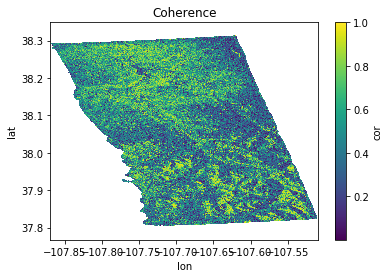

In [36]:
band.plot() #big array so pretty slow...
plt.title(band.attrs['long_name'])
# NOTE: could redo aspect ratio (see visualization notebook example from Randy LeVeque)
# Or use cartopy

(-107.85, -107.65)

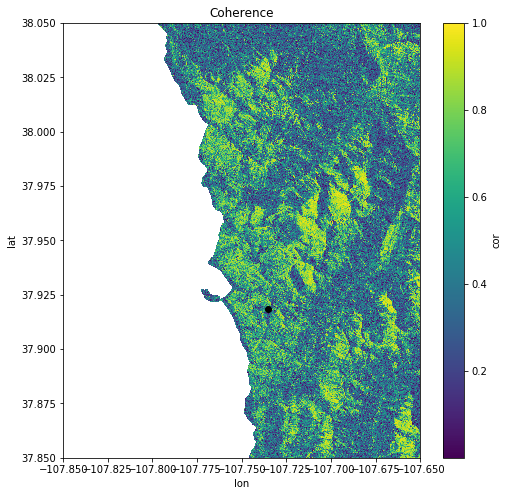

In [37]:
# Zoom in on specific spot
fig,ax = plt.subplots(figsize=(8,8))
band.plot(ax=ax) #big array so pretty slow...
plt.title(band.attrs['long_name'])
plt.plot(p1lon, p1lat, 'ko')
plt.ylim(37.85, 38.05)
plt.xlim(-107.85,  -107.65)

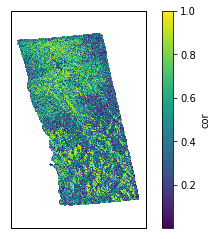

In [38]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
band.plot(ax=ax, transform=ccrs.PlateCarree()) #cmap=plt.cm.Blues, 

## Amplitude difference

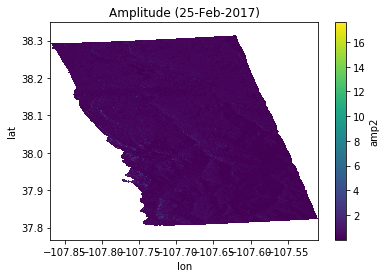

In [39]:
band = ds['amp2']
band[band==0.0] = np.nan
band.plot()
plt.title(band.attrs['long_name'])

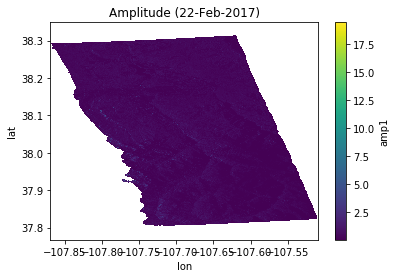

In [40]:
band = ds['amp1']
band[band==0.0] = np.nan
band.plot()
plt.title(band.attrs['long_name'])

(-107.85, -107.65)

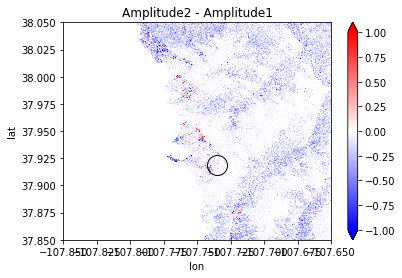

In [41]:
ampdiff = ds['amp2'] - ds['amp1']
#ampdiff[ampdiff==0.0] = np.nan #Error?
im = ampdiff.plot.imshow(vmin=-1, vmax=1, cmap='bwr')
plt.title('Amplitude2 - Amplitude1')
plt.plot(p1lon, p1lat, marker='o', ms=20, mec='k', mfc='None')
plt.ylim(37.85, 38.05)
plt.xlim(-107.85,  -107.65)
#plt.colorbar(im)
#plt.clim(-1,1) # Error

# Save modified netCDF

In [42]:
ds

<xarray.Dataset>
Dimensions:  (lat: 10460, lon: 6490)
Coordinates:
  * lat      (lat) float64 37.77 37.77 37.77 37.77 37.77 37.77 37.77 37.77 ...
  * lon      (lon) float64 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 -107.9 ...
Data variables:
    amp1     (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    amp2     (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    cor      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    hgt      (lat, lon) float64 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 -1e+04 ...
    unw      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    Slant Range Data Azimuth Spacing:          7.2
    Slant Range Data Range Spacing:            4.99654098
    Number of Looks in Range:                  3
    Number of Looks in Azimuth:                12
    Single Look Complex Data Azimuth Spacing:  0.6
    Single Look Complex Data Range Spacing:    1.66551366
    Average Look Angle in Near 

In [43]:
ds.to_netcdf('tellur_1701T_17016_mod.nc')
#NOTE: no CRS associated with data, so can't open in QGIS...
# gdalinfo tellur_1701T_17016_mod.nc
# gdal_translate -a_srs EPSG:4326 tellur_1701T_17016_mod.nc
# gdalwarp -of VRT -t_srs EPSG:32613 tellur_1701T_17016_mod.nc tellur_1701T_17016_mod.utm.vrt

# Read back in and see that metadata was preserved

In [44]:
dsnew = xr.open_dataset('tellur_1701T_17016_mod.nc') # In memory?!
#

# Ideas for future work

* run on amazon with server.py fron Johan
* extract values from all snowpit sights (geopandas?)
* Convert rasters to UTM w/ rasterio? 32
* Better colorbars on images
* turn netCDF into data cube (4 UAVSAR acquisition dates)
* try folium interactive plot
